In [1]:
import sys, os
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc
import gzip
from scipy.io import mmread
from pathlib import Path, PurePath
from sklearn.metrics import adjusted_rand_score

import scmomat 

plt.rcParams["font.size"] = 10

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_data(_dir):
    feat_names = pd.read_csv(join(_dir, 'features.tsv.gz'), compression='gzip', sep='\t', header=None)
    barcodes   = pd.read_csv(join(_dir, 'barcodes.tsv.gz'), compression='gzip', sep='\t', header=None)

    with gzip.open(join(_dir, 'matrix.mtx.gz'), 'rb') as gzipped_file:
        mat = mmread(gzipped_file)

    ad = sc.AnnData(sps.csr_matrix(mat.T))
    ad.obs_names = barcodes[0].values
    ad.var_names = feat_names[1].values
    ad.var['id'] = feat_names[0].values
    ad.var['type'] = feat_names[2].values
    return ad

import json
import copy
from matplotlib.image import imread
def load_spatial(path, adata, library_id='0'):
    tissue_positions_file = join(path, "tissue_positions.csv")
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=join(path, "scalefactors_json.json"),
        hires_image=join(path, "tissue_hires_image.png"),
        lowres_image=join(path, "tissue_lowres_image.png"),
    )
    
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()
    adata.uns["spatial"][library_id]["images"] = dict()
    for res in ["hires", "lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_bytes()
    )

    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header=0 if Path(tissue_positions_file).name == "tissue_positions.csv" else None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm["spatial"] = adata.obs[
        ["pxl_row_in_fullres", "pxl_col_in_fullres"]
    ].to_numpy()
   
    adata.obs.drop(
        columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
        inplace=True,
    )

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key, exclude=[]):
    aris = []
    for ad in ads:
        _mask = ~ad.obs[ref_key].isin(exclude)
        gt = ad.obs[ref_key].values[_mask]
        pred = ad.obs[src_key].values[_mask]
        aris.append(adjusted_rand_score(pred, gt))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

import copy
def std_prep(ad, n_hvg=5000, hvg_flav='v3', scale=False):
    ad.X = copy.deepcopy(ad.layers['counts'])
    
    if n_hvg and hvg_flav=='v3':
        sc.pp.highly_variable_genes(ad, n_top_genes=n_hvg, flavor='seurat_v3')
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    if n_hvg and hvg_flav=='v2':
        sc.pp.highly_variable_genes(ad, n_top_genes=n_hvg)
    if scale:
        sc.pp.scale(ad)
    sc.pp.pca(ad, n_comps=min(50, ad.n_vars-1))

### load dataset

In [4]:
data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_node/TN-2024-new/outs'

ad3 = load_data(join(data_dir, 'filtered_feature_bc_matrix'))
ad3_rna = ad3[:, ad3.var['type']=='Gene Expression'].copy()
ad3_adt = ad3[:, ad3.var['type']=='Antibody Capture'].copy()
load_spatial(join(data_dir, 'spatial'), ad3_rna)
load_spatial(join(data_dir, 'spatial'), ad3_adt)

ad3_rna.obs['src'] = ad3_adt.obs['src'] = ['s3']*ad3_rna.n_obs
ad3_rna.obs_names = [f's3-{x}' for x in ad3_rna.obs_names]
ad3_adt.obs_names = [f's3-{x}' for x in ad3_adt.obs_names]

ad3_rna.var_names_make_unique()
ad3_adt.var_names_make_unique()

data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_tonsil_ramen'

ad_a1_rna = sc.read_h5ad(join(data_dir, 'tonsil_A1/adata_RNA.h5ad'))
ad_a1_adt = sc.read_h5ad(join(data_dir, 'tonsil_A1/adata_ADT.h5ad'))
ad_a1_rna.var_names_make_unique()
ad_a1_adt.var_names_make_unique()
meta1 = pd.read_csv(join(data_dir, 'tonsil_A1/A1_TNSL_Kwoh.csv'), index_col=0) 
ad_a1_rna.obs['lab'] = meta1.loc[ad_a1_rna.obs_names, 'manual'].to_list()
ad_a1_adt.obs['lab'] = meta1.loc[ad_a1_adt.obs_names, 'manual'].to_list()
ad_a1_rna.obs['src'] = ad_a1_adt.obs['src'] = ['s1'] * ad_a1_rna.n_obs
ad_a1_rna.obs_names = [f's1-{x}' for x in ad_a1_rna.obs_names]
ad_a1_adt.obs_names = [f's1-{x}' for x in ad_a1_adt.obs_names]

ad_d1_rna = sc.read_h5ad(join(data_dir, 'tonsil_D1/adata_RNA.h5ad'))
ad_d1_adt = sc.read_h5ad(join(data_dir, 'tonsil_D1/adata_ADT.h5ad'))
ad_d1_rna.var_names_make_unique()
ad_d1_adt.var_names_make_unique()
meta2 = pd.read_csv(join(data_dir, 'tonsil_D1/D1_TNSL_cloupe_Kwoh.csv'), index_col=0) 
ad_d1_rna.obs['lab'] = meta2.loc[ad_d1_rna.obs_names, 'manual'].to_list()
ad_d1_adt.obs['lab'] = meta2.loc[ad_d1_adt.obs_names, 'manual'].to_list()
ad_d1_rna.obs['src'] = ['s2-rna'] * ad_d1_rna.n_obs
ad_d1_adt.obs['src'] = ['s2-adt'] * ad_d1_adt.n_obs
ad_d1_rna.obs_names = [f's2-rna-{x}' for x in ad_d1_rna.obs_names]
ad_d1_adt.obs_names = [f's2-adt-{x}' for x in ad_d1_adt.obs_names]

ad_a1_rna.obs['Sample'] = ad_a1_adt.obs['Sample'] = ['S1']*ad_a1_rna.n_obs
ad_d1_rna.obs['Sample'] = ad_d1_adt.obs['Sample'] = ['S2']*ad_d1_rna.n_obs

/tmp/ipykernel_14946/3635794731.py:59: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(sps.csr_matrix(mat.T))
/home/xuhua/xuhua_disco/miniforge3/envs/bento/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/bento/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/bento/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_uniqu

In [5]:
ad_rna_all = sc.concat([ad_a1_rna, ad_d1_rna, ad3_rna])
ad_adt_all = sc.concat([ad_a1_adt, ad_d1_adt, ad3_adt])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()
hvp_names = ad_adt_all.var_names.to_numpy()

### prepare count inputs

In [6]:
# READ IN THE COUNT MATRICES
counts_rnas = []
for adi in [ad_a1_rna, ad_d1_rna, None]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvg_names].X.A, modality = "RNA", log = False)
        counts_rnas.append(count)
    else:
        counts_rnas.append(None)

counts_adts = []
for adi in [ad_a1_adt, None, ad_d1_adt]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvp_names].X.A, modality = "ADT", log = True)
        counts_adts.append(count)
    else:
        counts_adts.append(None)

In [7]:
# CREATE THE COUNTS OBJECT
n_batches = 3
feats_name = {"rna": hvg_names, "adt": hvp_names}
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "adt": counts_adts}

### step 2: training scmomat

Input sanity check...
Finished.
Epoch 1, Validating Loss: 26.5152
	 loss reconstruction: 0.01652
	 loss regularization: 1.00000
Epoch 1000, Validating Loss: 10.9220
	 loss reconstruction: 0.01081
	 loss regularization: 0.01169
Epoch 2000, Validating Loss: 10.4368
	 loss reconstruction: 0.01021
	 loss regularization: 0.02244
Epoch 3000, Validating Loss: 9.9077
	 loss reconstruction: 0.00951
	 loss regularization: 0.04008
Epoch 4000, Validating Loss: 9.6767
	 loss reconstruction: 0.00930
	 loss regularization: 0.03782
running time: 137.33617687225342


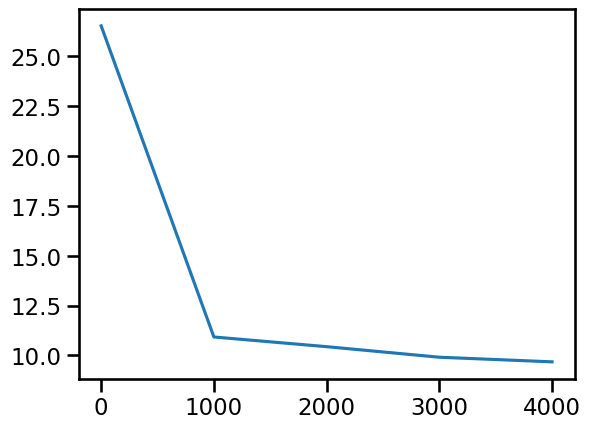

In [8]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 50
lamb = 0.01 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

#### inference

In [9]:
# umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 

if True:
    zs = model.extract_cell_factors()
    # np.save('./outputs/tonsil/rep1-rep2-rep3.npy', zs)
else:
    pass
    # zs = np.load('./outputs/tonsil/rep1-rep2-rep3.npy', allow_pickle=True)
    
# x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

In [10]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
# labels = [ad_a1_rna.obs.label, ad_d1_rna.obs.label, ad_test_adt.obs.label]
batches = ad_a1_rna.obs['src'].to_list() + ad_d1_rna.obs['src'].to_list() + ad_d1_adt.obs['src'].to_list()

### post-processing

### eval results

In [11]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
# ad_mosaic.obs['label'] = np.hstack(labels)
ad_mosaic.obs['batches'] = np.hstack(batches)
split_ob([ad_a1_adt, ad_d1_rna, ad_d1_adt], ad_mosaic, ob='obsm', key='X_emb')


### before batch corr

In [13]:
# lisi_res = eval_lisi(
#     ad_mosaic,
#     batch_keys=['batches'],
#     label_keys = [],
#     use_rep='X_emb', use_neighbors=False,
# )
# lisi_res['batches_iLISI'][0]


In [16]:
from lisi_bridge import eval_bridge
eval_bridge(
        ad_d1_rna, ad_d1_adt,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.26618
Match_score=0.00105


{'FOSCTTM': 0.266179712507898, 'Match_score': 0.0010533830761540997}

### after batch corr

In [17]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['batches'].to_list())
split_ob([ad_a1_adt, ad_d1_rna, ad_d1_adt], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


In [18]:
from lisi_bridge import eval_bridge
eval_bridge(
        ad_d1_rna, ad_d1_adt,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb_har',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.26224
Match_score=0.00145


{'FOSCTTM': 0.2622436134398682, 'Match_score': 0.0014525022887745486}

## Vis

In [19]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/Tonsil_modalMatch/scmomat'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=np.hstack([ad_a1_rna.obs_names, ad_d1_rna.obs_names, ad_d1_adt.obs_names]))
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=np.hstack([ad_a1_rna.obs_names, ad_d1_rna.obs_names, ad_d1_adt.obs_names]))
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [20]:
1

1